# Importing packages

In [1]:
import time
import subprocess
import seaborn as sns
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
import struct
from typing import Any, Dict
from kedro.config import ConfigLoader
from datetime import datetime
from sklearn.preprocessing import QuantileTransformer
%matplotlib inline


# Sample

### Selecting data with genotype and phenotype data

In [2]:
# Reading dataframe
pathPhenotypeData = '../../data/01_raw/hla_expression.tsv'
pathGenotypeSample = '../../data/01_raw/SampleTot.txt'

dfPhen_ = pd.read_csv(pathPhenotypeData, sep = "\t")
samplePhen_ = dfPhen_.drop_duplicates(['subject_id'])

print(f'''
SAMPLE WITH PHENOTYPE DATA:
{samplePhen_['pop'].value_counts()}

SIZE: {samplePhen_.shape[0]}
''')

sampleGen_ = pd.read_csv(pathGenotypeSample, sep = "\t")
print(f'''
SAMPLE WITH GENOTYPE DATA:
{sampleGen_.shape[0]}
''')



SAMPLE WITH PHENOTYPE DATA:
FIN    95
GBR    94
TSI    93
CEU    91
YRI    89
Name: pop, dtype: int64

SIZE: 462


SAMPLE WITH GENOTYPE DATA:
2504



In [3]:
sampleAnalysis = pd.merge(
                        samplePhen_,
                        sampleGen_,
                        how = 'inner'
)
print(f'''
SAMPLE TO ANALYSIS:
{sampleAnalysis['pop'].value_counts()}

TOTAL SIZE:
{sampleAnalysis.shape[0]}


LOST: 
{samplePhen_.shape[0] - sampleAnalysis.shape[0]}

{samplePhen_['pop'].value_counts() - sampleAnalysis['pop'].value_counts()}
''')


SAMPLE TO ANALYSIS:
FIN    92
TSI    91
CEU    89
YRI    87
GBR    86
Name: pop, dtype: int64

TOTAL SIZE:
445


LOST: 
17

CEU    2
FIN    3
GBR    8
TSI    2
YRI    2
Name: pop, dtype: int64



### Filtering samples

In [4]:
def createTempFolder(name_: str):
    # Create temporary folder
    conf_paths = ["../../conf/local"]
    conf_loader = ConfigLoader(conf_paths)
    parameters = conf_loader.get("paths*", "paths*/**")
    pathTemp = parameters['pathTemp']
    pathTempFiles = f'''{pathTemp}/{name_}'''
    proc_ = subprocess.Popen(['mkdir',pathTempFiles])
    proc_.wait()
    logging.info('Created temporary folder')
    return pathTempFiles

def selectSample(
    data: pd.DataFrame , 
    genoData: pd.DataFrame, 
    sampParams: dict, 
    pathTempFiles: str
    ) -> Dict[str, Any]:
    """
    Node for selecting the desired sample to work with.
    The parameters are taken from conf/project/parameters.yml.
    The data and the parameters will be loaded and provided to this function
    automatically when the pipeline is executed and it is time to run this node.
    """
    if sampParams['pop'] != None:
        data = data.loc[data['pop'].isin(sampParams['pop'])]
    if sampParams['sex'] != None:
        data = data.loc[data['sex'].isin(sampParams['sex'])]
    if sampParams['lab'] != None:
        data = data.loc[data['lab'].isin(sampParams['lab'])]
    # Merged data - intersection between genotyped and phenotyped individuals
    dfMerge = genoData.merge(data, how = 'inner')
    sizeOriginalDf = dfMerge.drop_duplicates(['subject_id']).shape[0]
    # logging.info('The original sample size is: ' + str(sizeOriginalDf))
    # Saving sample on temp folder
    if sampParams['outliers'] != None:
        from scipy.linalg import inv
        import numpy as np
        from scipy.stats import chi2
        cut_ = 1 - sampParams['outliers']
        gene_names = dfMerge.gene_name.unique()
        horizontalDf = dfMerge.pivot(index=['subject_id','sex','lab','pop'], columns=['gene_name'], values='tpm').reset_index()
        centeredValues = horizontalDf[gene_names] - horizontalDf[gene_names].mean()
        centeredValues.index = horizontalDf.subject_id
        covMatrix_ = np.cov(horizontalDf[gene_names].values.T)
        invCovMatrix_ = inv(covMatrix_)
        invCovMatrix_ = pd.DataFrame(invCovMatrix_)
        invCovMatrix_.index = gene_names
        invCovMatrix_.columns = gene_names
        mahalanobisMatrix = centeredValues @ invCovMatrix_ @ centeredValues.T
        mahalanobisFinal = np.diag(mahalanobisMatrix)
        mahalanobisFinal = pd.DataFrame(mahalanobisFinal)
        mahalanobisFinal.loc[:,'subject_id'] = horizontalDf.subject_id
        mahalanobisFinal.rename(columns = {0:'MahalanobisD'},inplace = True)
        mahalanobisFinal.loc[:,'Percentile'] = mahalanobisFinal.MahalanobisD.apply(lambda x: chi2.cdf(x,(len(gene_names))))
        mahalanobisFinal.loc[:,'cut'] = mahalanobisFinal.Percentile.apply(lambda x: 1 if x >= cut_ else 0)
        dfSample = mahalanobisFinal.loc[mahalanobisFinal.cut == 0 ,['subject_id']].copy().drop_duplicates()
    else:
        dfSample = dfMerge.loc[:,['subject_id']].copy().drop_duplicates()
        mahalanobisFinal = dfMerge
    print(f'The new sample size is: {dfSample.shape[0]}')
    dfSample.loc[:,'1'] = dfSample.subject_id
    dfSample.to_csv(pathTempFiles + '/sample.txt', index = False, header= False, sep = ' ')
    final_ = {'selectedSample':dfSample.loc[:,['subject_id']] , 'sizeOriginalDf':sizeOriginalDf , 'sizeFinalDf':dfSample.shape[0] , 'originalDf': dfMerge, 'MahalanobisDf': mahalanobisFinal,'pathAnalysis': pathTempFiles}
    return final_

### There will be 4 samples:
* 1 - Everyone, no outlier filters;
* 2 - Everyone, filtering out outliers based on Mahalanobis distance (percentile 99%);
* 3 - Europeans, no outlier filters;
* 4 - Europeans, filtering out outliers based on Mahalanobis distance (percentile 99%)

#### 1 - Everyone, no outlier filters

In [5]:
sampParams1 = {'pop': None,'sex':None,'lab':None,'outliers':None}
pathTemp1 = createTempFolder('sample1')

sample1 = selectSample(
                        dfPhen_.loc[dfPhen_.subject_id.isin(sampleAnalysis.subject_id)],
                        sampleGen_,
                        sampParams1,
                        pathTemp1
                        )
print(f'''
SIZE OF ORIGINAL SAMPLE:
{sample1['sizeOriginalDf']}
SIZE OF NEW SAMPLE
{sample1['sizeFinalDf']}
''')

The new sample size is: 445

SIZE OF ORIGINAL SAMPLE:
445
SIZE OF NEW SAMPLE
445



mkdir: cannot create directory ‘/scratch/genevol/users/lucas/sample1’: File exists


#### 2 - Everyone, filtering out outliers based on Mahalanobis distance (percentile 99%);

In [7]:
sampParams2 = {'pop': None,'sex':None,'lab':None,'outliers':.01}
pathTemp2 = createTempFolder('sample2')

sample2 = selectSample(
                        dfPhen_.loc[dfPhen_.subject_id.isin(sampleAnalysis.subject_id)],
                        sampleGen_,
                        sampParams2,
                        pathTemp2
                        )
print(f'''
SIZE OF ORIGINAL SAMPLE:
{sample2['sizeOriginalDf']}

DROPPED:
{sample2['sizeOriginalDf'] - sample2['sizeFinalDf']}


SIZE OF NEW SAMPLE
{sample2['sizeFinalDf']}
''')

mkdir: cannot create directory ‘/scratch/genevol/users/lucas/sample2’: File exists


The new sample size is: 417

SIZE OF ORIGINAL SAMPLE:
445

DROPPED:
28


SIZE OF NEW SAMPLE
417



In [8]:
selectedSample2 = sample2['selectedSample'].copy()

checkDrop2 = pd.merge(
                    dfPhen_.loc[dfPhen_.subject_id.isin(sampleAnalysis.subject_id)],
                    selectedSample2,
                    how = 'left',
                    indicator = True
)
checkDrop2H = checkDrop2.pivot(index=['subject_id','sex','lab','pop','_merge'], columns=['gene_name'], values='tpm').reset_index()
checkDrop2H.head(3)

gene_name,subject_id,sex,lab,pop,_merge,HLA-A,HLA-B,HLA-C,HLA-DPA1,HLA-DPB1,HLA-DQA1,HLA-DQB1,HLA-DRA,HLA-DRB1
0,HG00096,male,UNIGE,GBR,both,1604.34,2987.70,1087.53,357.38,268.77,398.84,215.55,1280.96,684.15
1,HG00097,female,LUMC,GBR,both,1342.20,2582.44,1019.52,485.48,300.73,638.74,406.08,1384.77,603.38
2,HG00099,female,HMGU,GBR,both,921.60,1407.62,602.12,169.41,128.43,248.45,135.38,573.15,437.87


In [9]:
pd.pivot_table(data = checkDrop2H.loc[checkDrop2H._merge == 'left_only'], index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count', margins = True).fillna(0).astype(int)

gene_name      sex                        
lab       CNAG_CRG HMGU MPIMG UNIGE UU All
pop                                       
CEU              3    1     3     2  2  11
GBR              2    0     0     0  0   2
TSI              2    0     1     0  1   4
YRI              6    1     3     1  0  11
All             13    2     7     3  3  28

<AxesSubplot: xlabel='gene_name-lab', ylabel='pop'>

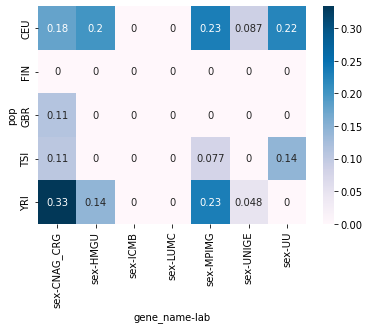

In [10]:
tab_ = pd.pivot_table(data = checkDrop2H.loc[checkDrop2H._merge == 'left_only'], index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count').fillna(0).astype(int) / pd.pivot_table(data = checkDrop2H, index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count').astype(int)
sns.heatmap(tab_.fillna(0),annot= True, cmap = 'PuBu')

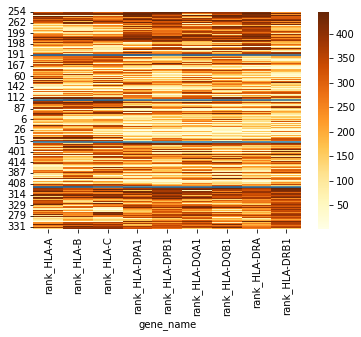

In [11]:
columnsRank = []
for x in checkDrop2H.columns:
    if 'HLA' in x:
        col_ = f'rank_{x}'
        checkDrop2H.loc[:,col_] = checkDrop2H[x].rank(axis = 0).astype(int)
        columnsRank.append(col_)
checkDrop2H.sort_values(['pop'], inplace = True)
checkDrop2H.loc[:,'aux'] = 1
checkDrop2H.loc[:,'indexes_'] = checkDrop2H.aux.cumsum()
args_ = checkDrop2H.groupby(['pop']).indexes_.max().reset_index()
ax = sns.heatmap(checkDrop2H.sort_values(['pop','_merge','lab','sex'])[columnsRank], cmap = 'YlOrBr')
ax.hlines(args_.indexes_.values[:-1], *ax.get_xlim())


In [78]:
list_ = ['_merge','lab','pop','sex']
[list_.append(x) for x in columnsRank]
tab_ = checkDrop2H.sort_values(['_merge','lab','pop','sex'])[list_].head(30).style.background_gradient(cmap = 'YlOrBr', axis = 0)
tab_

gene_name,_merge,lab,pop,sex,rank_HLA-A,rank_HLA-B,rank_HLA-C,rank_HLA-DPA1,rank_HLA-DPB1,rank_HLA-DQA1,rank_HLA-DQB1,rank_HLA-DRA,rank_HLA-DRB1
254,left_only,CNAG_CRG,CEU,female,228,390,349,432,443,191,424,436,277
182,left_only,CNAG_CRG,CEU,male,324,379,308,405,444,403,389,416,239
180,left_only,CNAG_CRG,CEU,male,392,419,421,336,445,193,308,444,370
70,left_only,CNAG_CRG,GBR,female,443,444,445,372,364,383,444,360,167
96,left_only,CNAG_CRG,GBR,male,437,440,422,72,335,335,14,233,434
373,left_only,CNAG_CRG,TSI,male,112,257,434,302,143,53,160,259,163
440,left_only,CNAG_CRG,TSI,male,193,298,444,123,106,208,301,47,305
291,left_only,CNAG_CRG,YRI,female,275,392,175,320,439,431,255,377,423
298,left_only,CNAG_CRG,YRI,female,445,345,235,439,433,436,445,432,443
306,left_only,CNAG_CRG,YRI,female,439,435,440,293,426,399,313,372,249


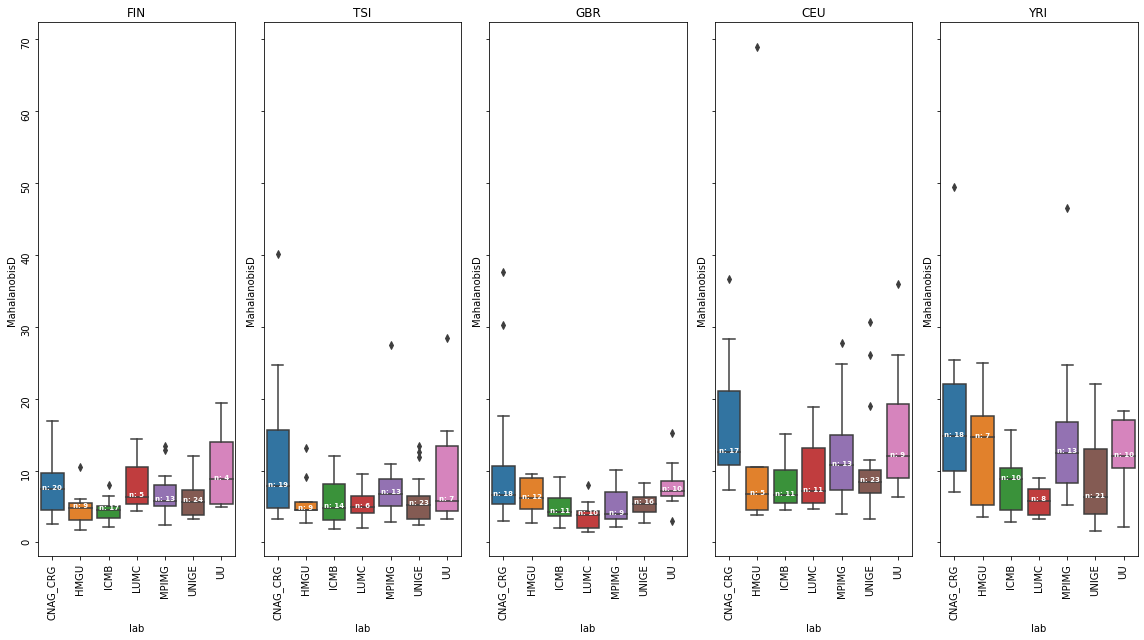

In [28]:
def bxPlt(ax_, pop_, dfRef_):
    df_ = dfRef_.loc[dfRef_['pop'] == pop_].sort_values(['lab'])
    sns.boxplot(data = df_, y = 'MahalanobisD', x = 'lab', ax = ax_)
    ax_.tick_params(labelrotation=90)
    ax_.set_title(pop_)
    medians = df_.groupby(['lab'])['MahalanobisD'].median().values
    nobs = df_.groupby(['lab']).sex.count().reset_index()
    nobs = [str(x) for x in nobs.sex.tolist()]
    nobs = ["n: " + i for i in nobs]
    pos = range(len(nobs))
    for tick,label in zip(pos,ax_.get_xticklabels()):
        ax_.text(pos[tick],
                medians[tick] + 0.03,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='w',
                weight='semibold')
    return 
    
mahalanobisDistribSamp2 = pd.merge(
                    dfPhen_.loc[dfPhen_.subject_id.isin(sampleAnalysis.subject_id)].drop_duplicates(['subject_id']),
                    sample2['MahalanobisDf'],
                    how = 'inner'
)


fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, sharey = True, sharex = True,figsize=(16,9))
bxPlt(ax0, 'FIN', mahalanobisDistribSamp2)
bxPlt(ax1, 'TSI', mahalanobisDistribSamp2)
bxPlt(ax2, 'GBR', mahalanobisDistribSamp2)
bxPlt(ax3, 'CEU', mahalanobisDistribSamp2)
bxPlt(ax4, 'YRI', mahalanobisDistribSamp2)
fig.tight_layout()





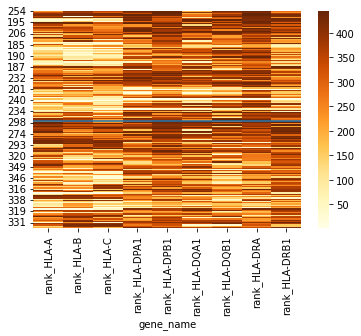

In [31]:
dfPlt = checkDrop2H.loc[checkDrop2H['pop'].isin(['CEU','YRI'])].sort_values(['pop','_merge','lab','sex'])
# dfPlt.groupby(['pop']).lab.count()

ax = sns.heatmap(dfPlt[columnsRank], cmap = 'YlOrBr')
ax.hlines([dfPlt.loc[dfPlt['pop'] == 'CEU'].shape[0]], *ax.get_xlim())

In [35]:
checkDrop2H.loc[checkDrop2H['pop'].isin(['CEU','YRI'])].sort_values(['_merge','pop','lab','sex'])[list_].head(30).style.background_gradient(cmap = 'YlOrBr', axis = 0)

gene_name,_merge,lab,pop,sex,rank_HLA-A,rank_HLA-B,rank_HLA-C,rank_HLA-DPA1,rank_HLA-DPB1,rank_HLA-DQA1,rank_HLA-DQB1,rank_HLA-DRA,rank_HLA-DRB1
254,left_only,CNAG_CRG,CEU,female,228,390,349,432,443,191,424,436,277
182,left_only,CNAG_CRG,CEU,male,324,379,308,405,444,403,389,416,239
180,left_only,CNAG_CRG,CEU,male,392,419,421,336,445,193,308,444,370
214,left_only,HMGU,CEU,female,414,421,424,445,434,272,383,445,420
221,left_only,MPIMG,CEU,male,351,10,277,391,317,291,433,425,412
245,left_only,MPIMG,CEU,male,412,415,418,440,382,89,324,420,232
224,left_only,MPIMG,CEU,male,115,136,87,407,307,324,280,419,436
222,left_only,UNIGE,CEU,female,26,19,106,426,316,443,440,414,431
259,left_only,UNIGE,CEU,female,71,162,33,299,339,424,329,441,405
195,left_only,UU,CEU,female,442,429,327,430,389,251,428,430,307


### 3 - Europeans, no outlier filters;

In [36]:
sampParams3 = {'pop': ['CEU','GBR','FIN','TSI'],'sex':None,'lab':None,'outliers':None}
pathTemp3 = createTempFolder('sample3')

sample3 = selectSample(
                        dfPhen_.loc[dfPhen_.subject_id.isin(sampleAnalysis.subject_id)],
                        sampleGen_,
                        sampParams3,
                        pathTemp3
                        )
print(f'''
SIZE OF ORIGINAL SAMPLE:
{sample3['sizeOriginalDf']}
SIZE OF NEW SAMPLE
{sample3['sizeFinalDf']}
''')

The new sample size is: 358

SIZE OF ORIGINAL SAMPLE:
358
SIZE OF NEW SAMPLE
358



mkdir: cannot create directory ‘/scratch/genevol/users/lucas/sample3’: File exists


### 4 - Europeans, filtering out outliers based on Mahalanobis distance (percentile 99%)

In [37]:
sampParams4 = {'pop': ['CEU','GBR','FIN','TSI'],'sex':None,'lab':None,'outliers':0.01}
pathTemp4 = createTempFolder('sample4')

sample4 = selectSample(
                        dfPhen_.loc[dfPhen_.subject_id.isin(sampleAnalysis.subject_id)],
                        sampleGen_,
                        sampParams4,
                        pathTemp4
                        )
print(f'''
SIZE OF ORIGINAL SAMPLE:
{sample4['sizeOriginalDf']}
SIZE OF NEW SAMPLE
{sample4['sizeFinalDf']}
''')

mkdir: cannot create directory ‘/scratch/genevol/users/lucas/sample4’: File exists


The new sample size is: 339

SIZE OF ORIGINAL SAMPLE:
358
SIZE OF NEW SAMPLE
339



In [38]:
selectedSample4 = sample4['selectedSample'].copy()

checkDrop4 = pd.merge(
                    dfPhen_.loc[(dfPhen_.subject_id.isin(sampleAnalysis.subject_id))&(dfPhen_['pop'].isin(['CEU','GBR', 'FIN','TSI']))],
                    selectedSample4,
                    how = 'left',
                    indicator = True
)
checkDrop4H = checkDrop4.pivot(index=['subject_id','sex','lab','pop','_merge'], columns=['gene_name'], values='tpm').reset_index()
checkDrop4H.head(3)

gene_name,subject_id,sex,lab,pop,_merge,HLA-A,HLA-B,HLA-C,HLA-DPA1,HLA-DPB1,HLA-DQA1,HLA-DQB1,HLA-DRA,HLA-DRB1
0,HG00096,male,UNIGE,GBR,both,1604.34,2987.70,1087.53,357.38,268.77,398.84,215.55,1280.96,684.15
1,HG00097,female,LUMC,GBR,both,1342.20,2582.44,1019.52,485.48,300.73,638.74,406.08,1384.77,603.38
2,HG00099,female,HMGU,GBR,both,921.60,1407.62,602.12,169.41,128.43,248.45,135.38,573.15,437.87


In [39]:
# Removed subjects
pd.pivot_table(data = checkDrop4H.loc[checkDrop4H._merge == 'left_only'], index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count', margins = True).fillna(0).astype(int)

gene_name      sex                        
lab       CNAG_CRG HMGU MPIMG UNIGE UU All
pop                                       
CEU              5    1     3     2  2  13
GBR              2    0     0     0  0   2
TSI              2    0     1     0  1   4
All              9    1     4     2  3  19

In [43]:
# Total
pd.pivot_table(data = checkDrop4H, index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count', margins = True).fillna(0).astype(int)

gene_name      sex                                    
lab       CNAG_CRG HMGU ICMB LUMC MPIMG UNIGE  UU  All
pop                                                   
CEU             17    5   11   11    13    23   9   89
FIN             20    9   17    5    13    24   4   92
GBR             18   12   11   10     9    16  10   86
TSI             19    9   14    6    13    23   7   91
All             74   35   53   32    48    86  30  358

<AxesSubplot: xlabel='gene_name-lab', ylabel='pop'>

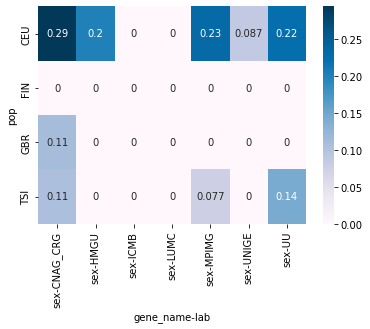

In [40]:
tab_ = pd.pivot_table(data = checkDrop4H.loc[checkDrop4H._merge == 'left_only'], index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count').fillna(0).astype(int) / pd.pivot_table(data = checkDrop4H, index = ['pop'], columns = ['lab'],values = ['sex'], aggfunc='count').astype(int)
sns.heatmap(tab_.fillna(0),annot= True, cmap = 'PuBu')

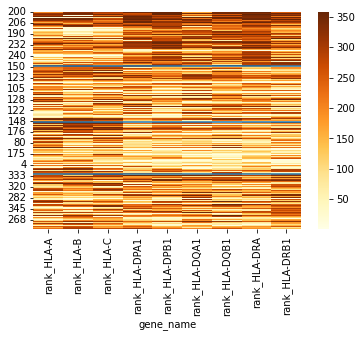

In [44]:
for x in checkDrop4H.columns:
    if 'HLA' in x:
        col_ = f'rank_{x}'
        checkDrop4H.loc[:,col_] = checkDrop4H[x].rank(axis = 0).astype(int)
checkDrop4H.sort_values(['pop'], inplace = True)
checkDrop4H.loc[:,'aux'] = 1
checkDrop4H.loc[:,'indexes_'] = checkDrop4H.aux.cumsum()
args_ = checkDrop4H.groupby(['pop']).indexes_.max().reset_index()
ax = sns.heatmap(checkDrop4H.sort_values(['pop','_merge','lab','sex'])[columnsRank], cmap = 'YlOrBr')
ax.hlines(args_.indexes_.values[:-1], *ax.get_xlim())


In [46]:
list_ = ['_merge','lab','pop','sex']
[list_.append(x) for x in columnsRank]
checkDrop4H.sort_values(['_merge','lab','pop','sex'])[list_].head(30).style.background_gradient(cmap = 'YlOrBr', axis = 0)

gene_name,_merge,lab,pop,sex,rank_HLA-A,rank_HLA-B,rank_HLA-C,rank_HLA-DPA1,rank_HLA-DPB1,rank_HLA-DQA1,rank_HLA-DQB1,rank_HLA-DRA,rank_HLA-DRB1
200,left_only,CNAG_CRG,CEU,female,224,238,185,201,348,354,268,340,351
254,left_only,CNAG_CRG,CEU,female,195,323,292,347,356,169,341,351,252
235,left_only,CNAG_CRG,CEU,female,311,346,281,263,354,343,351,335,350
182,left_only,CNAG_CRG,CEU,male,270,314,259,330,357,332,316,333,222
180,left_only,CNAG_CRG,CEU,male,326,338,344,277,358,171,254,357,314
70,left_only,CNAG_CRG,GBR,female,357,357,358,305,310,317,358,293,157
96,left_only,CNAG_CRG,GBR,male,354,353,345,69,292,286,13,204,352
353,left_only,CNAG_CRG,TSI,male,165,249,357,115,105,184,247,43,276
286,left_only,CNAG_CRG,TSI,male,97,216,351,254,138,50,136,225,155
214,left_only,HMGU,CEU,female,340,340,346,358,351,239,310,358,346


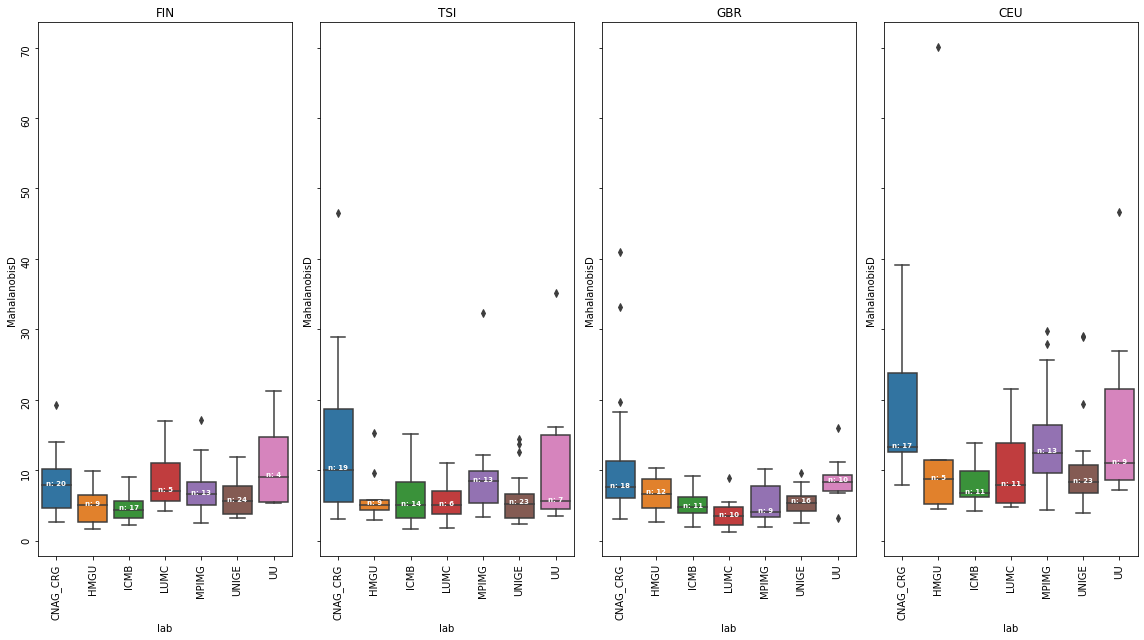

In [47]:
mahalanobisDistribSamp4 = pd.merge(
                    dfPhen_.loc[(dfPhen_.subject_id.isin(sampleAnalysis.subject_id))&(dfPhen_['pop'].isin(['CEU','FIN','GBR','TSI']))].drop_duplicates(['subject_id']),
                    sample4['MahalanobisDf'],
                    how = 'inner'
)

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, sharey = True, sharex = True,figsize=(16,9))
bxPlt(ax0,'FIN', mahalanobisDistribSamp4)
bxPlt(ax1,'TSI', mahalanobisDistribSamp4)
bxPlt(ax2,'GBR', mahalanobisDistribSamp4)
bxPlt(ax3,'CEU', mahalanobisDistribSamp4)
fig.tight_layout()

# Selecting snps

In [50]:
def checkLogSizes(path_,listNames_):
    listSizes = []
    for name_ in listNames_:
        try:
            size = os.path.getsize(path_ + '/' + name_)
        except:
            size = 0
    
        listSizes.append(size > 0)
    return listSizes
# Update status about process
def updateLog(path_,status_,file_):
    if status_ == 0:
        msg_ = str(datetime.now()) + ": Waiting..."
    else:
        msg_ = str(datetime.now()) + ": Done!"
    f = open(path_ + '/' + file_, "a")
    f.write(msg_ + '\n')
    f.close()
def monitoringProcess(pathTempFiles,listNames,statusFile_):
    # Check if all 22 .bed files are created
    sizes = checkLogSizes(pathTempFiles,listNames)
    cond = sum(sizes) < 22
    # If not, waits until so
    while cond:
        sizes = checkLogSizes(pathTempFiles,listNames)
        cond = sum(sizes) < 22
        if cond:
            # Updates status (inside tmp folder)
            updateLog(pathTempFiles,0,statusFile_ + ".txt")
            time.sleep(10)
        else:
            # Updates status (inside tmp folder)
            updateLog(pathTempFiles,1,statusFile_ + ".txt")
def createBedFiles(pathTempFiles:str, snpsParams: dict, nameFiles:str) -> None:
    conf_paths = ["../../conf/local"]
    conf_loader = ConfigLoader(conf_paths)
    parameters = conf_loader.get("paths*", "paths*/**")
    pathPlink = parameters['plink']
    pathVcf = parameters['pathVcfFiles']
    query_1 = pathPlink + " --vcf $input"
    if snpsParams['vif'] != None:
        query_1 += " --indep 50 5 " + str(snpsParams['vif'])
    if snpsParams['maf'] != None:
        query_1 += " --maf " + str(snpsParams['maf'])
    if snpsParams['hwe'] != None:
        query_1 += " --hwe " + str(snpsParams['hwe'])
    query_1 += f" --keep {pathTempFiles}/sample.txt --mind 0.05 --geno 0.05 --vcf-half-call missing --out $filtered"
    # check if files were already created
    checkCreatedFiles_ = checkLogSizes(pathTempFiles,[f'list_filt_snps_chr{chr_}_{nameFiles}.prune.in' for chr_ in range(1,23)])
    cond = sum(checkCreatedFiles_) < 22
    if cond:
        # Create .bed files - 22 chromossomes
        for chr_ in range(1,23):
            sbatchFile_1 = f'''input={pathVcf}/ALL.chr{chr_}_GRCh38.genotypes.20170504.vcf.gz
    filtered={pathTempFiles}/list_filt_snps_chr{chr_}_{nameFiles}
    eval {query_1}
            '''
            with open(pathTempFiles + '/filterSnps' + str(chr_) + '.sh', 'w') as f:
                f.write(sbatchFile_1)
                f.write('\n')
            cmd = ['sh', pathTempFiles + '/filterSnps' + str(chr_) + '.sh']
            print(sbatchFile_1)
            subprocess.Popen(cmd)
        monitoringProcess(pathTempFiles,[f'list_filt_snps_chr{chr_}_{nameFiles}.prune.in' for chr_ in range(1,23)],f'filteredSnpsStatus_{nameFiles}')
    checkCreatedFiles2_ = checkLogSizes(pathTempFiles,[f'chr{chr_}_{nameFiles}.bed' for chr_ in range(1,23)])
    cond2 = sum(checkCreatedFiles2_) < 22
    if cond2:
        query_2 = f'''{pathPlink} --vcf $input --vcf-half-call missing --extract $filtered --keep {pathTempFiles}/sample.txt --make-bed --out $bed'''
        for chr_ in range(1,23):
            sbatchFile_2 = f'''input={pathVcf}/ALL.chr{chr_}_GRCh38.genotypes.20170504.vcf.gz
    filtered={pathTempFiles}/list_filt_snps_chr{chr_}_{nameFiles}.prune.in
    bed={pathTempFiles}/chr{chr_}_{nameFiles}
    eval {query_2}
            '''
            print(sbatchFile_2)
            with open(pathTempFiles + '/bedMaker' + str(chr_) + '.sh', 'w') as f:
                f.write(sbatchFile_2)
                f.write('\n')
            cmd = ['sh', pathTempFiles + '/bedMaker' + str(chr_) + '.sh']
            subprocess.Popen(cmd)   
        monitoringProcess(pathTempFiles,[f'chr{chr_}_{nameFiles}.bed' for chr_ in range(1,23)],f'bedStatus_{nameFiles}')
    return None

In [51]:
vifs = [1.5, 2]
mafs = [.05, .1]
hwes = [10**-7, 10**-4]


configs_ = {}
iter_ = 1
for vif_, maf_, hwe_ in itertools.product(vifs, mafs, hwes):
    configs_[f'config_{iter_}'] = {'vif': vif_, 'maf': maf_, 'hwe': hwe_}
    iter_ +=1
configs_

{'config_1': {'vif': 1.5, 'maf': 0.05, 'hwe': 1e-07},
 'config_2': {'vif': 1.5, 'maf': 0.05, 'hwe': 0.0001},
 'config_3': {'vif': 1.5, 'maf': 0.1, 'hwe': 1e-07},
 'config_4': {'vif': 1.5, 'maf': 0.1, 'hwe': 0.0001},
 'config_5': {'vif': 2, 'maf': 0.05, 'hwe': 1e-07},
 'config_6': {'vif': 2, 'maf': 0.05, 'hwe': 0.0001},
 'config_7': {'vif': 2, 'maf': 0.1, 'hwe': 1e-07},
 'config_8': {'vif': 2, 'maf': 0.1, 'hwe': 0.0001}}

In [52]:
for i in range(1,9):
    # All 8 scenarios for entire sample
    createBedFiles(pathTemp1,configs_[f'config_{i}'],f'config_{i}')
    # All 8 scenarios for entire sample, but removing outliers
    createBedFiles(pathTemp2,configs_[f'config_{i}'],f'config_{i}')
    # All 8 scenarios for europeans
    createBedFiles(pathTemp3,configs_[f'config_{i}'],f'config_{i}')
    # All 8 scenarios for europeans
    createBedFiles(pathTemp4,configs_[f'config_{i}'],f'config_{i}')


## Example of calls:

### Select Snps
input=/raid/genevol/vcf_1000G/phase3_20130502_grch38positions/ALL.chr1_GRCh38.genotypes.20170504.vcf.gz<br />
filtered=/scratch/genevol/users/lucas/sample1/list_filt_snps_chr1_config_1<br /><br />
eval /raid/genevol/users/lucas/plink1_9/plink --vcf $input --indep 50 5 1.5 --maf 0.05 --hwe 1e-07 --keep /scratch/genevol/users/lucas/sample1/sample.txt --mind 0.05 --geno 0.05 --vcf-half-call missing --out $filtered

### Produce bed files

input=/raid/genevol/vcf_1000G/phase3_20130502_grch38positions/ALL.chr1_GRCh38.genotypes.20170504.vcf.gz<br />
filtered=/scratch/genevol/users/lucas/sample1/list_filt_snps_chr1_config_1.prune.in<br />
bed=/scratch/genevol/users/lucas/sample1/chr1_config_1<br /><br />
eval /raid/genevol/users/lucas/plink1_9/plink --vcf $input --vcf-half-call missing --extract $filtered --keep /scratch/genevol/users/lucas/sample1/sample.txt --make-bed --out $bed

# Building matrices

## GCTA

In [53]:
import time
import subprocess
import struct
import pickle
import pandas as pd
import os
import numpy as np
import itertools
from pathlib import Path
from os.path import exists
from multiprocessing import Pool
from kedro.config import ConfigLoader
from datetime import datetime
from bed_reader import open_bed

In [54]:
def calculateGCTA(args_):
    f'''
    Builds the GCTA matrix.
    args_: dict
        pathRef_: path to files (reference to bed files + samples)
        nameFile: name of the reference file (bed files)
        nameMatrix: name of the final matrix (output)
        numThreads_: number of threads to calculate matrix

    '''
    pathRef_ = args_['pathRef_']
    nameFile = args_['nameFile']
    nameMatrix = args_['nameMatrix']
    numThreads_ = args_['numThreads_']
    conf_paths = ["../../conf/local"]
    conf_loader = ConfigLoader(conf_paths)
    parameters = conf_loader.get("paths*", "paths*/**")
    pathGCTA_ = parameters['gcta']
    if nameMatrix != None:
        nameMatrix_ = 'GCTA_' + nameMatrix
    else:
        nameMatrix_ = 'GCTA'
    file_ = open(f'{pathRef_}/REF_BEDS_{nameFile}', 'w')
    [file_.write(f'{pathRef_}/chr{chr_}_{nameFile}\n') for chr_ in range(1,23)]
    file_.close()
    cmd = [pathGCTA_, '--mbfile' ,f'{pathRef_}/REF_BEDS_{nameFile}', '--keep', f'{pathRef_}/sample.txt' ,'--make-grm','--out',f'{pathRef_}/{nameMatrix_}','--thread-num',str(numThreads_)]
    subprocess.Popen(cmd)
    # check whether GRM binaries already exists - means process is finished
    check_ = Path(f'{pathRef_}/{nameMatrix_}.grm.bin')
    cond = check_.is_file()
    while not cond:
        cond = check_.is_file()
        if not cond:
            # Updates status (inside tmp folder)
            print(f'''
            STILL PROCESSING {nameMatrix_}
            WAITING MORE 10S
            ''')
            time.sleep(10)
        else:
            # Updates status (inside tmp folder)
            print(f'''
            {nameMatrix_} DONE!
            ''')

In [60]:
for samp_, config_ in itertools.product([x for x in range(1,5)],[x for x in range(1,9)]):
    configGCTA_ = {
                    'pathRef_': f'/scratch/genevol/users/lucas/sample{samp_}'
                    , 'nameFile': f'config_{config_}'
                    , 'nameMatrix': f'config_{config_}_raw'
                    , 'numThreads_': 10
                    }
    calculateGCTA(configGCTA_)

## Example call:

/raid/genevol/users/lucas/gcta/gcta64 --mbfile /scratch/genevol/users/lucas/sample1/REF_BEDS_config1 --keep /scratch/genevol/users/lucas/sample1/sample.txt --make-grm --out /scratch/genevol/users/lucas/sample1/config_1_raw --thread-num 10

PS: REF_BEDS_config1 - file, containing path of bed files

## K<sub>c-1</sub>

In [61]:
class calculateMatrixes:
    def __init__(self,params):
        self.chromosomes_ = params["chromosomes"]
        self.pathAnalysis_ = params["pathAnalysis"]
        self.nameFile_ = params["nameFile_"]
        self.alpha = params["alpha"]
        self.cores_ = params["cores"]
        self.nameMatrix_ = params["nameMatrix_"]
        self.sample_ = pd.read_csv(f'{self.pathAnalysis_}/sample.txt', header = None, sep = ' ', usecols = [0], names = ['subject_id'])
    def Bool_(self,x,comp_):
        if x in comp_:
            return True
        else:
            return False
    def readBedsMP(self,chr_):
        bed = open_bed(f'{self.pathAnalysis_}/chr{chr_}_{self.nameFile_}.bed')
        val = bed.read()
        boolArray_ = [self.Bool_(x,self.sample_.subject_id.values) for x in bed.iid]
        filterRows = val[boolArray_]
        return chr_, filterRows
    def readBeds(self):
        matrixes_ = {}
        p = Pool(self.cores_)
        with p:
            results = p.map(self.readBedsMP,self.chromosomes_)
        for i_ in range(len(self.chromosomes_)):
            result_ = results[i_]
            chr_ = result_[0]
            mat_ = result_[1]
            matrixes_[chr_] = mat_
        self.matrixes_ = matrixes_
    def eliminateBadColumns(self):
        correctedMatrixes = {}
        for chr_ in self.chromosomes_:
            tempMatrix = self.matrixes_[chr_].copy()
            # Calculates std after subtracting values by the mean and replacing by 0 nan values 
            # (equivalent to replace by the mean)
            stds_ = np.nan_to_num(tempMatrix - tempMatrix.mean(axis = 0)).std(axis = 0)
            checkVar = np.where(stds_ == 0)
            if len(checkVar) > 0:
                correctedMatrix_ = np.nan_to_num(np.delete(tempMatrix,checkVar, axis = 1))
                print(f'''
                REMOVING {checkVar[0].shape[0]} SNPS ON CHROMOSOME {chr_}-> VARIANCE IS EQUAL TO ZERO
                ''')
            else:
                correctedMatrix_ = np.nan_to_num(tempMatrix.copy())
            correctedMatrixes[chr_] = correctedMatrix_.copy()
        self.correctedMatrixDef = correctedMatrixes
    def calculateMatrix(self):
        ncolsDict = {}
        zzts_ = {}
        for i_,chr_ in enumerate(self.chromosomes_):
            tempMatrix_ = self.correctedMatrixDef[chr_].copy()
            means_ = tempMatrix_.mean(axis = 0)
            stds_ = tempMatrix_.std(axis = 0)
            ncols_ = tempMatrix_.shape[1]
            ncolsDict[chr_] = ncols_
            Z_ = ((tempMatrix_ - means_) * ((stds_)**self.alpha))
            ZZt_ = Z_ @ Z_.T
            zzts_[chr_] = ZZt_
            if i_ == 0:
                zztMatrixes = ZZt_.copy()
            else: 
                zztMatrixes += ZZt_
        self.zztMatrixes = zztMatrixes.copy()
        self.ncolsMatrixes = ncolsDict
        self.zzts_ = zzts_
    def calculateFinalMatrix(self):
        for i_,chr_ in enumerate(self.chromosomes_):
            if i_ == 0:
                nTot = self.ncolsMatrixes[chr_]
            else:
                nTot += self.ncolsMatrixes[chr_]
        self.nTot = nTot
        self.zztFinal = self.zztMatrixes / self.nTot

In [62]:
for samp_, config_ in itertools.product([x for x in range(1,5)],[x for x in range(1,9)]):
    args_ = {
                'chromosomes': [x for x in range(1, 23)]
                , 'pathAnalysis': f'/scratch/genevol/users/lucas/sample{samp_}'
                , 'nameFile_': f'config_{config_}'
                , 'alpha': -1
                , 'cores': 22
                # It will be added the number of remaining snps on the name of the final matrix
                , 'nameMatrix_': f'KC_MINUS_ONE_config_{config_}_raw'
            }

    if not exists(f'''{args_['pathAnalysis']}/{args_['nameMatrix_']}.pkl'''):
        start_ = time.time()
        runKC = calculateMatrixes(args_)
        print('READING BED FILES')
        runKC.readBeds()
        print('ELIMINATING BAD COLUMNS -> VARIANCE 0')
        runKC.eliminateBadColumns()
        print('CALCULATING MATRIX')
        runKC.calculateMatrix()
        runKC.calculateFinalMatrix()
        desiredMatrix = runKC.zztFinal
        print('SAVING FINAL MATRIX')
        with open(f'''{args_['pathAnalysis']}/{args_['nameMatrix_']}_{runKC.nTot}.pkl''','wb') as f_:
            pickle.dump(desiredMatrix, f_)
        end_ = time.time()
        print(f'''
                PRODUCED: {args_['pathAnalysis']}/{args_['nameMatrix_']}.pkl
                TIME TAKEN: {end_ - start_}s -> {(end_ - start_)/60}min
                ''')
    else:
        print(f'''K_C_{args_['alpha']}_{args_['nameMatrix_']} already calculated!''')


## Extracting eigen values K<sub>c-1</sub>

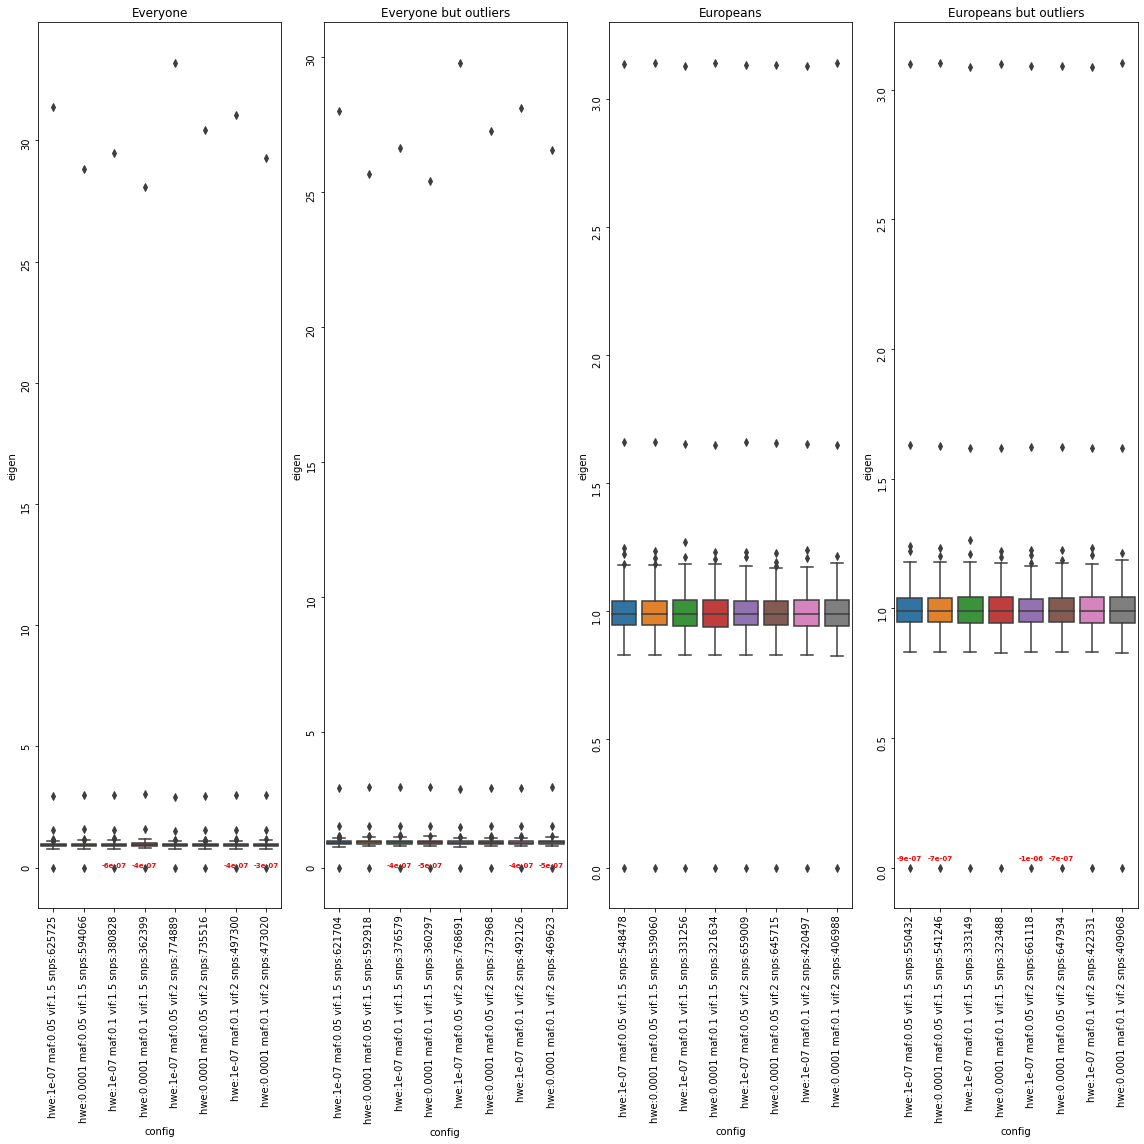

In [67]:
def generateData(root_):
    dfs_ = []
    for file_ in os.listdir(root_):
        if '.pkl' in file_:
            matrix_ = pickle.load(open(f'{root_}/{file_}','rb'))
            nameFile = file_.split('raw_')[1]
            qtSnps = int(nameFile.replace('.pkl',''))
            nameFile = file_.split('config_')[1]
            configNumber_ = nameFile[0]
            w,v = np.linalg.eig(matrix_)
            df_ = pd.DataFrame(w,columns=['eigen'])
            df_.loc[:, 'qtSnps'] = qtSnps
            config_ = configs_[f'config_{configNumber_}']
            df_.loc[:, 'configNumber'] = configNumber_
            df_.loc[:, 'fileName'] = file_
            df_.loc[:,'vif'] = config_['vif']
            df_.loc[:,'maf'] = config_['maf']
            df_.loc[:,'hwe'] = config_['hwe']
            df_.loc[:,'config'] = 'hwe:' + df_.hwe.astype(str) + ' maf:' + df_.maf.astype(str) + ' vif:' + df_.vif.astype(str) + ' snps:' + df_.qtSnps.astype(str)
            if df_.eigen.min() < 0:
                df_.loc[:,'negative'] = 1
            else:
                df_.loc[:,'negative'] = 0
            dfs_.append(df_)
    finalDf_ = pd.concat(dfs_, axis = 0, ignore_index = True)
    return finalDf_    

def bxPltKC(root_, ax_, title_):
    dfBxPlt = generateData(root_)
    sns.boxplot(data = dfBxPlt, y = 'eigen', x = 'config', ax = ax_, )
    ax_.tick_params(labelrotation=90)
    ax_.set_title(title_)
    # medians = dfBxPlt.groupby(['config'])['eigen'].median().values
    numberSnps = dfBxPlt.groupby(['config'])['qtSnps'].max().values.astype(str)
    negativeFlag = dfBxPlt.groupby(['config'])['negative'].max().values
    mins_ = dfBxPlt.groupby(['config'])['eigen'].min().values
    numberSnps = ["snps: " + i for i in numberSnps]
    pos = range(len(numberSnps))
    for tick,label in zip(pos,ax_.get_xticklabels()):
        # ax_.text(pos[tick],
        #         medians[tick] + .03,
        #         numberSnps[tick],
        #         horizontalalignment='center',
        #         size='x-small',
        #         color='red',
        #         rotation = 'vertical',
        #         weight='semibold')
        if negativeFlag[tick] == 1:
            ax_.text(pos[tick],
                    mins_[tick] + 0.03,
                    np.round(mins_[tick],7),
                    horizontalalignment='center',
                    size='x-small',
                    color='red',
                    weight='semibold')
    return ax_
    
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4,  sharex = False,figsize=(16,16))
bxPltKC('/scratch/genevol/users/lucas/sample1/', ax0, 'Everyone')
bxPltKC('/scratch/genevol/users/lucas/sample2/', ax1, 'Everyone but outliers')
bxPltKC('/scratch/genevol/users/lucas/sample3/', ax2, 'Europeans')
bxPltKC('/scratch/genevol/users/lucas/sample4/', ax3, 'Europeans but outliers')
# * 1 - Everyone, no outlier filters;
# * 2 - Everyone, filtering out outliers based on Mahalanobis distance (percentile 99%);
# * 3 - Europeans, no outlier filters;
# * 4 - Europeans, filtering out outliers based on Mahalanobis distance (percentile 99%)
fig.tight_layout()

<AxesSubplot: title={'center': 'Europeans but outliers'}, xlabel='config', ylabel='eigen'>

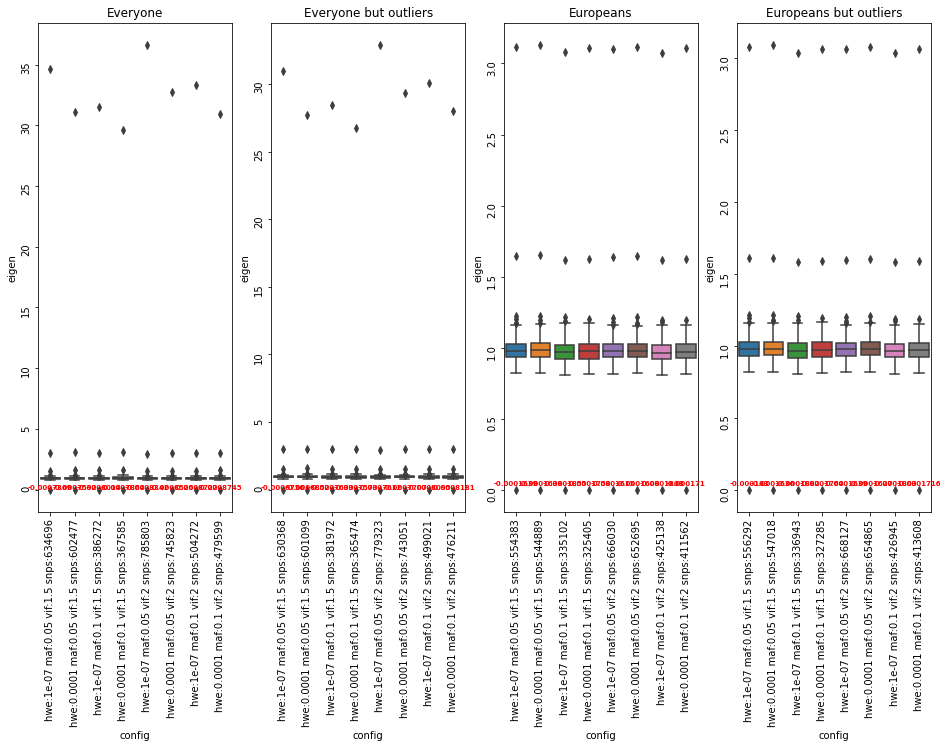

In [69]:
def readBinaryGCTA(file_):
    t_ = pd.read_csv(f'{file_}.grm.id', sep = '\t', header = None)
    n_ = t_.shape[0]
    biteSize = 4
    totalElements = int(n_ * (n_ + 1) / 2)
    values_ = []
    with open(f'{file_}.grm.bin','rb') as binFile_:
        for i_ in range(totalElements):
            values_.append(struct.unpack('f',binFile_.read(biteSize))[0])
    dfIndex = pd.DataFrame([x for x in range(n_)], columns = ['index_'])
    dfIndex.loc[:,'index_'] = dfIndex.index_ + 1
    dfIndex.loc[:, 'indexC_'] = dfIndex.index_.cumsum()
    dfIndex.loc[:, 'indexDiagonal'] = dfIndex.indexC_
    indexDiagonal = dfIndex.indexDiagonal.values - 1
    diagonalMatrix = [values_[x] for x in indexDiagonal]
    offDiagonalMatrix = [values_[x] for x in range(len(values_)) if x not in indexDiagonal]
    # Build matrix from binary files
    gctaMatrix_ = np.zeros([n_,n_])
    cont_ = 0
    contDiag_ = 0
    for col_ in range(n_):
        for row_ in range(n_):
            if row_ < col_:
                gctaMatrix_[row_,col_] = offDiagonalMatrix[cont_]
                gctaMatrix_[col_,row_] = offDiagonalMatrix[cont_]
                cont_ += 1
            if row_ == col_:
                gctaMatrix_[row_,col_] = diagonalMatrix[contDiag_]
                contDiag_ += 1
    return gctaMatrix_
def generateDataGCTA(root_):
    dfs_ = []
    for file_ in os.listdir(root_):
        if 'grm.bin' in file_ and 'CORRECTION' not in file_ and 'KC' not in file_:
            fileRoot_ = f'''{root_}/{file_.split('.grm.bin')[0]}'''
            # print(fileRoot_)
            matrix_ = readBinaryGCTA(fileRoot_)
            with open(f'{fileRoot_}.log','r') as f_:
                for line_ in f_.readlines():
                    if 'Used' in line_:
                        qtSnps = int(line_.split('valid')[0].replace('Used','').strip())
            # print(qtSnps)
            nameFile = file_.split('config_')[1]
            configNumber_ = nameFile[0]
            w,v = np.linalg.eig(matrix_)
            df_ = pd.DataFrame(w,columns=['eigen'])
            df_.loc[:, 'qtSnps'] = qtSnps
            config_ = configs_[f'config_{configNumber_}']
            df_.loc[:, 'configNumber'] = configNumber_
            df_.loc[:, 'fileName'] = fileRoot_
            df_.loc[:,'vif'] = config_['vif']
            df_.loc[:,'maf'] = config_['maf']
            df_.loc[:,'hwe'] = config_['hwe']
            df_.loc[:,'config'] = 'hwe:' + df_.hwe.astype(str) + ' maf:' + df_.maf.astype(str) + ' vif:' + df_.vif.astype(str) + ' snps:' + df_.qtSnps.astype(str)
            if df_.eigen.min() < 0:
                df_.loc[:,'negative'] = 1
            else:
                df_.loc[:,'negative'] = 0
            dfs_.append(df_)
    finalDf_ = pd.concat(dfs_, axis = 0, ignore_index = True)
    return finalDf_    

def bxPltGCTA(root_, ax_, title_):
    dfBxPlt = generateDataGCTA(root_)
    sns.boxplot(data = dfBxPlt, y = 'eigen', x = 'config', ax = ax_, )
    ax_.tick_params(labelrotation=90)
    ax_.set_title(title_)
    # medians = dfBxPlt.groupby(['config'])['eigen'].median().values
    numberSnps = dfBxPlt.groupby(['config'])['qtSnps'].max().values.astype(str)
    negativeFlag = dfBxPlt.groupby(['config'])['negative'].max().values
    mins_ = dfBxPlt.groupby(['config'])['eigen'].min().values
    numberSnps = ["snps: " + i for i in numberSnps]
    pos = range(len(numberSnps))
    for tick,label in zip(pos,ax_.get_xticklabels()):
        # ax_.text(pos[tick],
        #         medians[tick] + .03,
        #         numberSnps[tick],
        #         horizontalalignment='center',
        #         size='x-small',
        #         color='red',
        #         rotation = 'vertical',
        #         weight='semibold')
        if negativeFlag[tick] == 1:
            ax_.text(pos[tick],
                    mins_[tick] + 0.03,
                    np.round(mins_[tick],7),
                    horizontalalignment='center',
                    size='x-small',
                    color='red',
                    weight='semibold')
    return ax_

fig, (ax0, ax1,ax2, ax3) = plt.subplots(1, 4,  sharey = False,sharex = False,figsize=(16,9))
bxPltGCTA('/scratch/genevol/users/lucas/sample1/', ax0, 'Everyone')
bxPltGCTA('/scratch/genevol/users/lucas/sample2/', ax1, 'Everyone but outliers')
bxPltGCTA('/scratch/genevol/users/lucas/sample3/', ax2, 'Europeans')
bxPltGCTA('/scratch/genevol/users/lucas/sample4/', ax3, 'Europeans but outliers')


## Creating essential files for each configuration

In [72]:
def executeAnalysis(list_):
    grmV, phenoV, covsV, outV = list_[0], list_[1], list_[2], list_[3]
    gctaLoc = '/raid/genevol/users/lucas/gcta/gcta64'
    method = '--reml'
    algorithm = '--reml-alg'
    algorithmV = '0'
    maxit = '--reml-maxit'
    maxitV = '1000'
    grm = '--grm'
    pheno =  '--pheno'
    covs = '--covar'
    fix = '--reml-est-fix'
    out = '--out'

    cmd = [gctaLoc, method, algorithm, algorithmV, maxit, maxitV, grm, grmV, pheno, phenoV, covs, covsV, fix, out, outV]
    # Execute analysis
    p = subprocess.Popen(cmd,stdout=open(os.devnull, 'wb'))
    p.wait()
    # Reading results
    lines_ = {}
    indexes_ = []
    with (open(f'{outV}.log','r')) as f_:
        for i_,line_ in enumerate(f_.readlines()):
            split_ = line_.split('\t')
            lines_[i_] = split_
            if 'V(G)/Vp' in line_:
                herit_ = float(split_[1])
                seHerit_ = float(split_[2])
            if 'Log-likelihood' in split_[0]:
                indexes_.append(i_ - 1)
    try:
        logL = lines_[indexes_[0]][1]
    except:
        logL = 0
    if 'herit_' in locals():
        return herit_, seHerit_, logL
    else:
        return -99, -99, 0

def writeBinaryMatrixGCTA(matrix_, fileOut_, fileCP_):
    with open(f'{fileOut_}.grm.bin','wb') as f_:
        for row_ in range(matrix_.shape[0]):
            for col_ in range(matrix_.shape[1]):
                if row_ >= col_:
                    d = struct.pack('f', matrix_[row_,col_])
                    f_.write(d)
        f_.close()
    cmd = ['cp', fileCP_, f'{fileOut_}.grm.id']
    # Execute analysis
    p = subprocess.Popen(cmd,stdout=open(os.devnull, 'wb'))
    p.wait()

In [75]:
basicCols = ['subject_id']
covs_ = ['lab','sex']
resultsGCTA = []
X_ = basicCols.copy()
Y_ = basicCols.copy()
Y_.append('tpm')
for cov_ in covs_:
    X_.append(cov_)
for sample_ in range(1,5):
    root_ = f'/scratch/genevol/users/lucas/sample{sample_}'
    GCTAInfo = generateDataGCTA(root_)
    GCTAInfo = GCTAInfo.drop(columns = ['eigen','config']).drop_duplicates()
    individuals_ = pd.read_csv(f'''{root_}/sample.txt''',sep = ' ', header = None)
    individuals_.columns = ['subject_id','del_']
    individuals_.drop(columns = ['del_'], inplace = True)
    GCTAInfo.loc[:,'sampleSize'] = individuals_.shape[0]
    # print(f'''
    # SAMPLE: {sample_}
    # SAMPLE SIZE: {individuals_.shape[0]}
    # ''')
    resultsConf_ = GCTAInfo.copy()
    resultsConf_.loc[:,'corrected'] = 0
    resultsConf_.loc[:,'yTransform'] = 'No'
    resultsConf_.loc[:,'sample'] = sample_
    resultsConf_.loc[:,'type_'] = 'GCTA'
    for i_ in range(GCTAInfo.shape[0]):
        tuple_ = resultsConf_.iloc[i_]
        fileName = tuple_['fileName']
        if tuple_['negative'] == 1:
            copyTuple = pd.DataFrame(tuple_).T
            desiredMatrix = readBinaryGCTA(fileName)
            try:
                choleskyDecomp_ = np.linalg.cholesky(desiredMatrix)
                a = 1
            except:
                a = 0
            if a == 0:
                newMatrix = desiredMatrix.copy()
                while a == 0:
                    eigenValues, eigenVectors = np.linalg.eig(newMatrix)
                    minEigen = np.min(abs(eigenValues))
                    # print(minEigen)
                    reg_ = abs(minEigen) + 1e-6
                    newDiag = np.diag(eigenValues + reg_)
                    newMatrix = eigenVectors @ newDiag @ eigenVectors.T
                    try: 
                        np.linalg.cholesky(newMatrix)
                        a = 1
                    except:
                        a = 0
            writeBinaryMatrixGCTA(newMatrix, f'{fileName}_CORRECTION', f'{fileName}.grm.id')
        for geneExpr_ in dfPhen_.gene_name.unique():
            dbToMerge = individuals_.copy()
            covariatesX = dfPhen_.loc[dfPhen_.gene_name == geneExpr_,X_]
            expressionY = dfPhen_.loc[dfPhen_.gene_name == geneExpr_,Y_]
            XPop_ = pd.concat([dbToMerge.loc[:,['subject_id']] , dbToMerge.merge(covariatesX)] , axis = 1)
            YPop_ = pd.concat([dbToMerge.loc[:,['subject_id']] , dbToMerge.merge(expressionY)] , axis = 1)
            XPop_.to_csv(f'{root_}/X_.txt' ,sep = ' ',index = False, header = False)
            YPop_.to_csv(f'{root_}/Y_.txt' ,sep = ' ',index = False, header = False)
            list_ = [fileName, f'{root_}/Y_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
            info_ = executeAnalysis(list_)
            tempResults = tuple_.copy()
            tempResults['geneName'] = geneExpr_
            tempResults = list(tempResults)
            tempResults.extend(info_)
            resultsGCTA.append(tempResults)
            del(tempResults)
            quantile = QuantileTransformer(output_distribution='normal', n_quantiles = individuals_.shape[0])
            YPop_.loc[:,'tpm'] = quantile.fit_transform(YPop_.loc[:,'tpm'].values.reshape(-1,1))
            YPop_.to_csv(f'{root_}/YTransform_.txt' ,sep = ' ',index = False, header = False)
            list_ = [fileName, f'{root_}/YTransform_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
            info_ = executeAnalysis(list_)
            tempResults = tuple_.copy()
            tempResults['geneName'] = geneExpr_
            tempResults['yTransform'] = 'Quantile'
            tempResults = list(tempResults.values)
            tempResults.extend(info_)
            resultsGCTA.append(tempResults)
            del(tempResults)
            if tuple_['negative'] == 1:
                list_ = [f'{fileName}_CORRECTION', f'{root_}/Y_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
                info_ = executeAnalysis(list_)
                tempResults = tuple_.copy()
                tempResults['geneName'] = geneExpr_
                tempResults['corrected'] = 1
                tempResults = list(tempResults.values)
                tempResults.extend(info_)
                resultsGCTA.append(tempResults)
                del(tempResults)
                list_ = [f'{fileName}_CORRECTION', f'{root_}/YTransform_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
                info_ = executeAnalysis(list_)
                tempResults = tuple_.copy()
                tempResults['geneName'] = geneExpr_
                tempResults['corrected'] = 1
                tempResults['yTransform'] = 'Quantile'
                tempResults = list(tempResults.values)
                tempResults.extend(info_)
                resultsGCTA.append(tempResults)
                del(tempResults)



In [76]:
basicCols = ['subject_id']
covs_ = ['lab','sex']
resultsKC = []
X_ = basicCols.copy()
Y_ = basicCols.copy()
Y_.append('tpm')
for cov_ in covs_:
    X_.append(cov_)
for sample_ in range(1,5):
    root_ = f'/scratch/genevol/users/lucas/sample{sample_}'
    kcInfo = generateData(root_)
    kcInfo = kcInfo.drop(columns = ['eigen','config']).drop_duplicates()
    individuals_ = pd.read_csv(f'''{root_}/sample.txt''',sep = ' ', header = None)
    individuals_.columns = ['subject_id','del_']
    individuals_.drop(columns = ['del_'], inplace = True)
    kcInfo.loc[:,'sampleSize'] = individuals_.shape[0]
    # print(f'''
    # SAMPLE: {sample_}
    # SAMPLE SIZE: {individuals_.shape[0]}
    # ''')
    resultsConf_ = kcInfo.copy()
    resultsConf_.loc[:,'corrected'] = 0
    resultsConf_.loc[:,'yTransform'] = 'No'
    resultsConf_.loc[:,'sample'] = sample_
    resultsConf_.loc[:,'type_'] = 'KC'
    for i_ in range(kcInfo.shape[0]):
        tuple_ = resultsConf_.iloc[i_]
        fileName = tuple_['fileName'].replace('.pkl','')
        configNumber_ = tuple_['configNumber']
        desiredMatrix = pickle.load(open(f'{root_}/{fileName}.pkl','rb'))
        writeBinaryMatrixGCTA(desiredMatrix, f'{root_}/{fileName}', f'{root_}/GCTA_config_{configNumber_}_raw.grm.id')
        if tuple_['negative'] == 1:
            copyTuple = pd.DataFrame(tuple_).T
            desiredMatrix = pickle.load(open(f'{root_}/{fileName}.pkl','rb'))
            try:
                choleskyDecomp_ = np.linalg.cholesky(desiredMatrix)
                a = 1
            except:
                a = 0
            if a == 0:
                newMatrix = desiredMatrix.copy()
                while a == 0:
                    eigenValues, eigenVectors = np.linalg.eig(newMatrix)
                    minEigen = np.min(abs(eigenValues))
                    # print(minEigen)
                    reg_ = abs(minEigen) + 1e-6
                    newDiag = np.diag(eigenValues + reg_)
                    newMatrix = eigenVectors @ newDiag @ eigenVectors.T
                    try: 
                        np.linalg.cholesky(newMatrix)
                        a = 1
                    except:
                        a = 0
            writeBinaryMatrixGCTA(newMatrix, f'{root_}/{fileName}_CORRECTION', f'{root_}/GCTA_config_{configNumber_}_raw.grm.id')
        for geneExpr_ in dfPhen_.gene_name.unique():
            dbToMerge = individuals_.copy()
            covariatesX = dfPhen_.loc[dfPhen_.gene_name == geneExpr_,X_]
            expressionY = dfPhen_.loc[dfPhen_.gene_name == geneExpr_,Y_]
            XPop_ = pd.concat([dbToMerge.loc[:,['subject_id']] , dbToMerge.merge(covariatesX)] , axis = 1)
            YPop_ = pd.concat([dbToMerge.loc[:,['subject_id']] , dbToMerge.merge(expressionY)] , axis = 1)
            XPop_.to_csv(f'{root_}/X_.txt' ,sep = ' ',index = False, header = False)
            YPop_.to_csv(f'{root_}/Y_.txt' ,sep = ' ',index = False, header = False)
            list_ = [f'{root_}/{fileName}', f'{root_}/Y_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
            info_ = executeAnalysis(list_)
            tempResults = tuple_.copy()
            tempResults['geneName'] = geneExpr_
            tempResults = list(tempResults)
            tempResults.extend(info_)
            resultsKC.append(tempResults)
            del(tempResults)
            quantile = QuantileTransformer(output_distribution='normal', n_quantiles = individuals_.shape[0])
            YPop_.loc[:,'tpm'] = quantile.fit_transform(YPop_.loc[:,'tpm'].values.reshape(-1,1))
            YPop_.to_csv(f'{root_}/YTransform_.txt' ,sep = ' ',index = False, header = False)
            list_ = [f'{root_}/{fileName}', f'{root_}/YTransform_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
            info_ = executeAnalysis(list_)
            tempResults = tuple_.copy()
            tempResults['geneName'] = geneExpr_
            tempResults['yTransform'] = 'Quantile'
            tempResults = list(tempResults.values)
            tempResults.extend(info_)
            resultsKC.append(tempResults)
            del(tempResults)
            if tuple_['negative'] == 1:
                list_ = [f'{root_}/{fileName}_CORRECTION', f'{root_}/Y_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
                info_ = executeAnalysis(list_)
                tempResults = tuple_.copy()
                tempResults['geneName'] = geneExpr_
                tempResults['corrected'] = 1
                tempResults = list(tempResults.values)
                tempResults.extend(info_)
                resultsKC.append(tempResults)
                del(tempResults)
                list_ = [f'{root_}/{fileName}_CORRECTION', f'{root_}/YTransform_.txt', f'{root_}/X_.txt', f'{root_}/logExecution']
                info_ = executeAnalysis(list_)
                tempResults = tuple_.copy()
                tempResults['geneName'] = geneExpr_
                tempResults['corrected'] = 1
                tempResults['yTransform'] = 'Quantile'
                tempResults = list(tempResults.values)
                tempResults.extend(info_)
                resultsKC.append(tempResults)
                del(tempResults)



In [77]:
cols_ = [x for x in kcInfo.columns]
cols_.extend(['corrected', 'yTransform', 'sample', 'type_','geneName','herit', 'seHerit','logLikelihood'])
resultsDfKC_ = pd.DataFrame(resultsKC)
resultsDfKC_.columns = cols_
resultsDfGCTA_ = pd.DataFrame(resultsGCTA)
resultsDfGCTA_.columns = cols_
resultsDf = pd.concat([resultsDfKC_, resultsDfGCTA_], axis = 0, ignore_index = True)
resultsDf.to_csv('/home/lucas/kedro_heritability/heritability/finalResults.txt', sep = '|', decimal = ',', index = False)